In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

sns.set_theme(style="whitegrid", palette="tab10")  # pick one theme
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
os.chdir("..")
print(os.getcwd())

C:\Users\User\Downloads\Citibike-Weather-Dashboard


In [3]:
DAILY_PATH = r"Data\Processed\citibike_weather_merged_2022.csv"
daily = pd.read_csv(DAILY_PATH, parse_dates=["date"], index_col="date")
daily.head()

,daily_trips,avg_trip_duration_min,precip_mm,temp_avg_c,temp_max_c,temp_min_c
date,,,,,,


In [4]:
trip_files = sorted(glob.glob(r"Data\Raw\citibike-2022\*.csv"))
if len(trip_files) == 0:
    raise FileNotFoundError("No trip files found under Data\\Raw\\citibike-2022\\*.csv")

# Read just the station column (reduce memory)
sample_cols = pd.read_csv(trip_files[0], nrows=1).columns.tolist()
start_station_candidates = [c for c in sample_cols if "start" in c.lower() and "station" in c.lower() and "name" in c.lower()]
if not start_station_candidates:
    raise KeyError("Could not find a start station name column in trip data.")

START_STATION_COL = start_station_candidates[0]
START_STATION_COL

'start_station_name'

In [5]:
stations = pd.concat(
    (pd.read_csv(f, usecols=[START_STATION_COL], low_memory=False) for f in trip_files),
    ignore_index=True
)
top20 = stations[START_STATION_COL].value_counts().head(20).reset_index()
top20.columns = ["start_station", "count"]
top20.head()

,start_station,count
0,Grove St PATH,42556
1,South Waterfront Walkway - Sinatra Dr & 1 St,34245
2,Hoboken Terminal - River St & Hudson Pl,33020
3,Hoboken Terminal - Hudson St & Hudson Pl,30244
4,City Hall - Washington St & 1 St,23289


## Seaborn bar chart:

C:\Users\User\AppData\Local\Temp\ipykernel_33884\2516153875.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top20, y="start_station", x="count", palette="viridis")


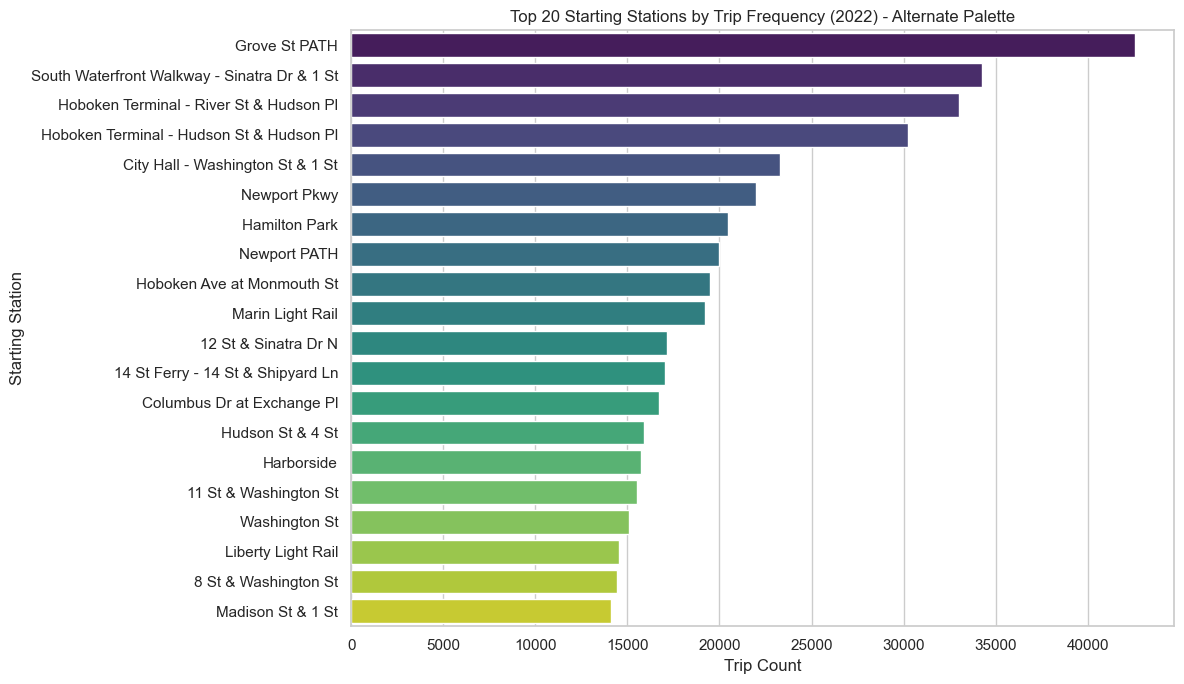

In [7]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=top20, y="start_station", x="count", palette="viridis")
ax.set_title("Top 20 Starting Stations by Trip Frequency (2022) - Alternate Palette")
ax.set_xlabel("Trip Count")
ax.set_ylabel("Starting Station")
plt.tight_layout()
plt.show()

## Recreate dual-axis line plot using seaborn:

In [15]:
print("daily shape:", daily.shape)
print("daily columns:", daily.columns.tolist())
print("daily index dtype:", getattr(daily.index, "dtype", None))

daily shape: (0, 6)
daily columns: ['daily_trips', 'avg_trip_duration_min', 'precip_mm', 'temp_avg_c', 'temp_max_c', 'temp_min_c']
daily index dtype: object


In [16]:
import pandas as pd

DAILY_PATH = r"Data\Processed\citibike_weather_daily_2022.csv"

daily = pd.read_csv(DAILY_PATH)

# If the file has a 'date' column, use it:
if "date" in daily.columns:
    daily["date"] = pd.to_datetime(daily["date"], errors="coerce")
    daily = daily.set_index("date").sort_index()
else:
    # Otherwise treat the first column as the date index
    daily.iloc[:, 0] = pd.to_datetime(daily.iloc[:, 0], errors="coerce")
    daily = daily.set_index(daily.columns[0]).sort_index()
    daily.index.name = "date"

daily.shape, daily.head()

((365, 6),
             daily_trips  avg_trip_duration_min  precip_mm  temp_avg_c  \
 date                                                                    
 2022-01-01          592              42.144369       19.3        11.6   
 2022-01-02         1248              27.255155        1.0        11.4   
 2022-01-03          832              24.766146        0.0         1.4   
 2022-01-04          934              17.051035        0.0        -2.7   
 2022-01-05          914               9.903556        6.1         3.2   
 
             temp_max_c  temp_min_c  
 date                                
 2022-01-01        13.9        10.0  
 2022-01-02        15.6         3.9  
 2022-01-03         3.9        -4.3  
 2022-01-04         2.2        -6.0  
 2022-01-05         8.9         0.0  )

In [17]:
daily.index.min(), daily.index.max(), daily.shape

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'), (365, 6))

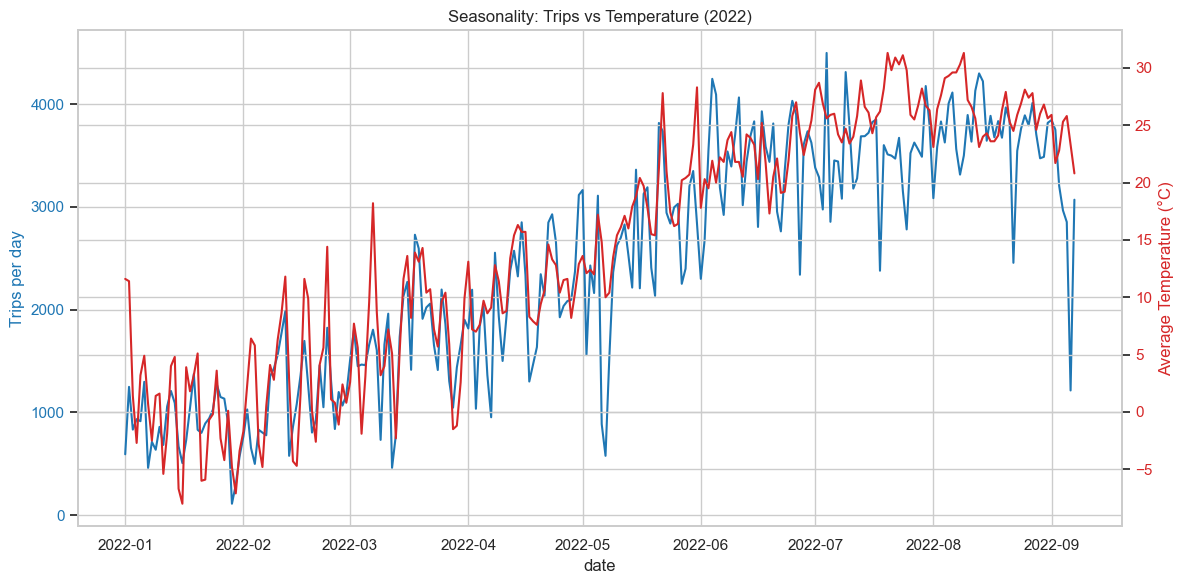

In [18]:
plot_df = daily.reset_index()

plot_df["daily_trips"] = pd.to_numeric(plot_df["daily_trips"], errors="coerce")
plot_df["temp_avg_c"] = pd.to_numeric(plot_df["temp_avg_c"], errors="coerce")
plot_df = plot_df.dropna(subset=["date", "daily_trips", "temp_avg_c"])

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(data=plot_df, x="date", y="daily_trips", ax=ax1, color="tab:blue")
ax1.set_ylabel("Trips per day", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
sns.lineplot(data=plot_df, x="date", y="temp_avg_c", ax=ax2, color="tab:red")
ax2.set_ylabel("Average Temperature (°C)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.set_title("Seasonality: Trips vs Temperature (2022)")
fig.tight_layout()
plt.show()

This visualization recreates the seasonality analysis by plotting daily Citi Bike trip counts and average daily temperature on a shared time axis using Seaborn. Because the two variables are on different scales, a secondary y-axis was created using Matplotlib’s twinx() method. Seaborn was used to render both line plots for consistent styling, while Matplotlib handled axis management and labeling. This approach follows the object-oriented Matplotlib paradigm, allowing fine-grained control over multiple axes within the same figure.

In [21]:
# Identify likely columns from one file
cols = pd.read_csv(trip_files[0], nrows=1).columns.tolist()
cols

# Common newer schema:
start_col = "started_at" if "started_at" in cols else "starttime"
end_col = "ended_at" if "ended_at" in cols else "stoptime"

cat_col = "member_casual" if "member_casual" in cols else ("usertype" if "usertype" in cols else None)
if cat_col is None:
    raise KeyError("No obvious rider category column found (member_casual/usertype).")

usecols = [start_col, end_col, cat_col]
usecols

['started_at', 'ended_at', 'member_casual']

In [22]:
trips_small = pd.concat(
    (pd.read_csv(f, usecols=usecols, low_memory=False) for f in trip_files),
    ignore_index=True
)

trips_small[start_col] = pd.to_datetime(trips_small[start_col])
trips_small[end_col] = pd.to_datetime(trips_small[end_col])
trips_small["trip_minutes"] = (trips_small[end_col] - trips_small[start_col]).dt.total_seconds() / 60

# Clean: keep reasonable durations
box_df = trips_small[(trips_small["trip_minutes"] > 0) & (trips_small["trip_minutes"] < 180)].copy()
box_df.head()

,started_at,ended_at,member_casual,trip_minutes
0,2022-01-26 18:50:39,2022-01-26 18:51:53,member,1.233333
1,2022-01-28 13:14:07,2022-01-28 13:20:23,member,6.266667
2,2022-01-10 19:55:13,2022-01-10 20:00:37,member,5.400000
3,2022-01-26 07:54:57,2022-01-26 07:55:22,member,0.416667
4,2022-01-13 18:44:46,2022-01-13 18:45:43,member,0.950000


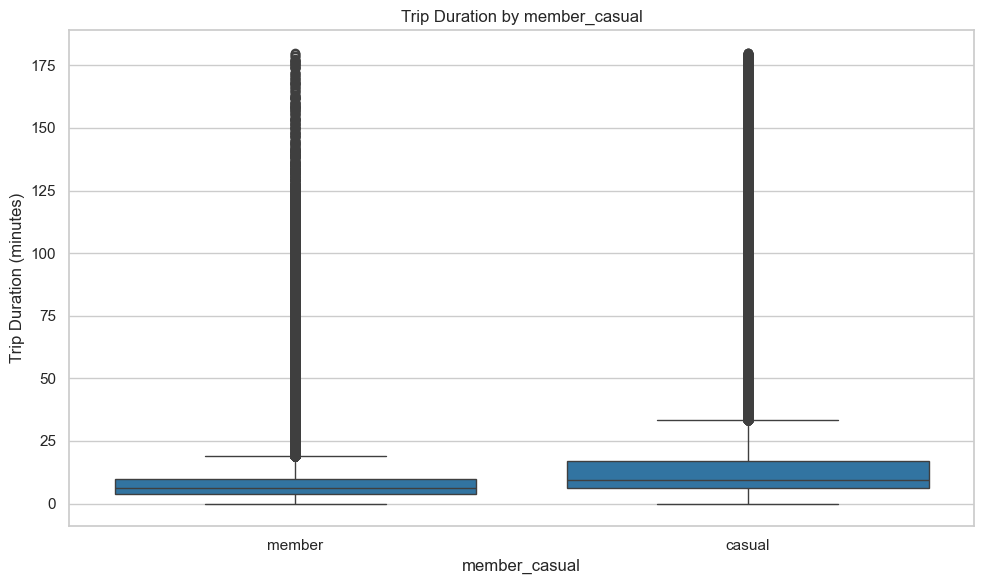

In [23]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=box_df, x=cat_col, y="trip_minutes")
ax.set_title(f"Trip Duration by {cat_col}")
ax.set_xlabel(cat_col)
ax.set_ylabel("Trip Duration (minutes)")
plt.tight_layout()
plt.show()

### Box Plot Analysis

This box plot compares trip duration across the selected categories. The median line shows the typical duration for each group, while the box (IQR) indicates the middle 50% of trips and highlights differences in variability. Longer whiskers and numerous outliers suggest that a meaningful portion of rides are substantially longer than the typical trip, which may reflect recreational use or irregular travel patterns. Differences in medians and IQRs across categories indicate that rider behavior varies by category, not only in typical duration but also in consistency of trip length.


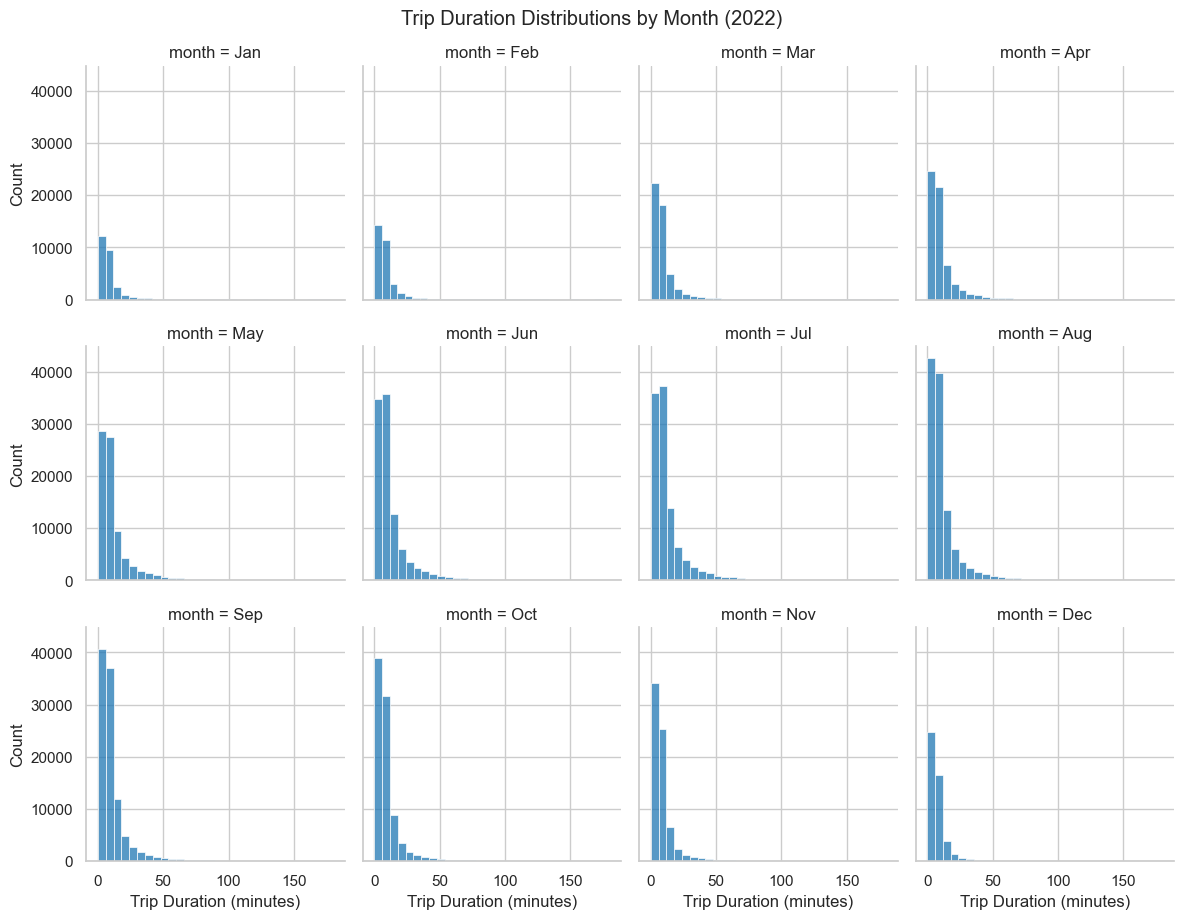

In [24]:
box_df["month"] = box_df[start_col].dt.month_name().str[:3]
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

g = sns.FacetGrid(box_df, col="month", col_order=month_order, col_wrap=4, height=3.0, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="trip_minutes", bins=30)
g.set_axis_labels("Trip Duration (minutes)", "Count")
g.fig.suptitle("Trip Duration Distributions by Month (2022)", y=1.02)
plt.show()

### FacetGrid Insight

The FacetGrid makes seasonal differences visible by showing each month’s duration distribution separately instead of averaging the entire year together. Months with heavier right tails indicate a larger share of long rides, consistent with more recreational usage during warmer seasons. This view supports more precise interpretation of seasonality because it separates monthly behavior rather than masking it in aggregate.
